In [1]:
# %% This example shows how to apply a pretrained denoising network to perform plug-and-play reconstruction.
# This exploits the idea that a simple Gaussian denoiser can be extrapolated to other applications, such as CT reconstruction.
# Ideally you want to use this denoiser as a prox operator or a regularizer in an iterative reconstruction algorithm.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard imports
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

# Torch imports
import torch

import deepinv

# Lion imports
from LION.classical_algorithms import fdk
from LION.experiments import ct_experiments
from LION.reconstructors import PnPReconstructor

/home/t/micromamba/envs/lion_proposed_no_pytorch_channel/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/t/micromamba/envs/lion_proposed_no_pytorch_channel/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata 

In [4]:
# % Chose device:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [5]:
experiment = ct_experiments.LowDoseCTRecon(dataset="LIDC-IDRI")
lidc_dataset = experiment.get_training_dataset()

Preparing patient list, this may take time....
Patient lists ready for train dataset


In [6]:
def ssim_torch(target: torch.Tensor, input: torch.Tensor) -> float:
    """Adapt SSIM function for torch tensors."""
    target = target.cpu().numpy().squeeze()
    input = input.cpu().numpy().squeeze()
    return structural_similarity(target, input, data_range=target.max() - target.min())


# Get pretrained DRUNet denoiser
denoiser = deepinv.models.DRUNet(pretrained="download", device=device)


def estimate_sigma(ct_image: torch.Tensor) -> float:
    top_left_air = ct_image[:50, :50]  # The top-left corner is usually background air.
    sigma_est = torch.std(top_left_air)  # Estimate noise level from background.
    return sigma_est.item()


def denoiser_fn(ct_image: torch.Tensor, sigma: float = None) -> torch.Tensor:
    with torch.no_grad():
        if sigma is None:
            sigma = estimate_sigma(ct_image)  # Estimate noise level if not provided.
            print(f"Estimated sigma: {sigma:.3f}")
        ct_image = ct_image.repeat(1, 3, 1, 1)  # grayscale 2D to 4-channel batch
        denoised = denoiser(ct_image, sigma=sigma)
        denoised = torch.mean(denoised, dim=1)  # average the channels to get grayscale
    return denoised


def denoiser_fn_admm(ct_image: torch.Tensor) -> torch.Tensor:
    # Denoiser's input sigma used in PnP can be different from the estimated value. It can even be adaptive.
    return denoiser_fn(ct_image, sigma=0.06)


reconstructor = PnPReconstructor(
    experiment.geometry, denoiser=denoiser_fn_admm, algorithm="ADMM"
)

Estimated sigma: 0.507


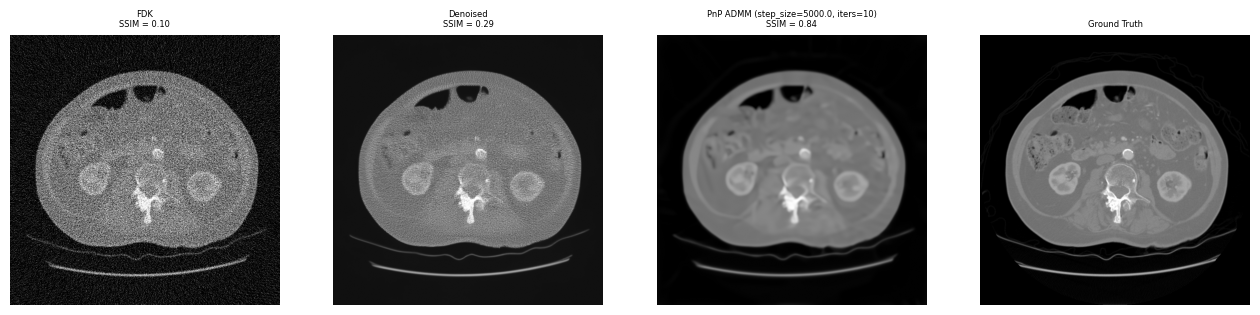

Estimated sigma: 0.521


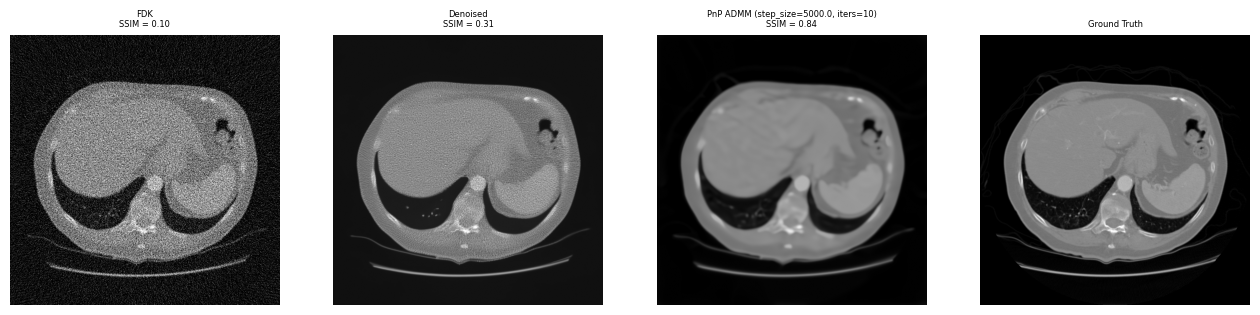

Estimated sigma: 0.486


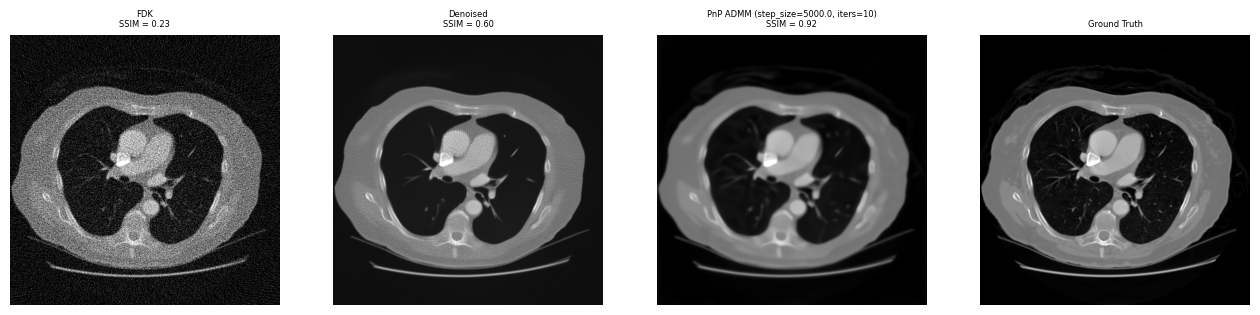

In [7]:
admm_iterations = 10
admm_step_size = 5e3

for i, (sino, target) in enumerate(lidc_dataset):
    if i >= 3:
        break
    sino: torch.Tensor = sino.unsqueeze(0)  # Add batch dimension
    target: torch.Tensor = target.unsqueeze(0)  # Add batch dimension

    sino = sino.to(device)
    target = target.to(device)
    recon = fdk(sino, op=experiment.geometry)

    denoised = denoiser_fn(recon.clone()).unsqueeze(0)

    # PnP reconstruction
    pnp_admm_result = reconstructor.reconstruct_sample(
        sino.squeeze(0),
        eta=admm_step_size,
        max_iter=admm_iterations,
        cg_max_iter=100,
        cg_tol=1e-7,
    ).unsqueeze(0)

    n_subplots = 4
    plt.figure(figsize=(n_subplots * 4, 4))

    plt.subplot(1, n_subplots, 1)
    plt.imshow(recon[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "FDK" + "\nSSIM = {:.2f}".format(ssim_torch(target[0], recon[0])), fontsize=6
    )

    plt.subplot(1, n_subplots, 2)
    plt.imshow(denoised[0, 0].cpu(), cmap="gray")
    plt.clim(0, 2)
    plt.axis("off")
    plt.title(
        "Denoised" + "\nSSIM = {:.2f}".format(ssim_torch(target[0], denoised[0])),
        fontsize=6,
    )

    plt.subplot(1, n_subplots, 3)
    plt.imshow(pnp_admm_result[0, 0].cpu(), cmap="gray")
    plt.title(
        f"PnP ADMM (step_size={admm_step_size}, iters={admm_iterations})"
        + "\nSSIM = {:.2f}".format(ssim_torch(target[0], pnp_admm_result[0])),
        fontsize=6,
    )
    plt.clim(0, 2)
    plt.axis("off")

    plt.subplot(1, n_subplots, n_subplots)
    plt.imshow(target[0, 0].cpu(), cmap="gray")
    plt.title("Ground Truth", fontsize=6)
    plt.axis("off")
    plt.clim(0, 2)

    plt.savefig(
        f"test_{i}--admm_stepsize{admm_step_size:.2e}_iters{admm_iterations}.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
# exit()

The end-to-end denoiser has the tendency to force some very sharp edges and divide the surfaces into more uniform regions, which gives the reconstruction a cartoon-like appearance and leads to loss of details.

In this example, we fixed the denoiser's input `sigma` parameter for PnP to a value smaller than the estimated value using part of the background of the FDK reconstruction, since a high value would oversmooth the image. It is also not recommended to estimate `sigma` for each ADMM iteration in the same way as for FDK, since the denoiser tends to smooth the background too much compared to the foreground right after the first iteration, making later estimates of sigma too small which results in insufficient denoising. 

That's it! We have successfully run a PnP reconstruction with a pretrained DRUNet as denoiser prior.